# IST-718 Lab 09
## Leonard Armstrong

---

This file contains the multi-layer perceptron neural network version for Fashion-MNIST image classification.

---

## IMPORTS

All required libraries are imported here. In general, we try to always prefix calles to functions with the libraries so as to make clear where they live. 

In [1]:
#--------------------------------------------------------------------------------------------------
# %% IMPORTS SECTION

import os
import pickle
import random                           # Sample
import time

import matplotlib        as mpl
import matplotlib.pyplot as plt
import numpy             as np          # Histogram of large array
import pandas            as pd
import sklearn.datasets  as skds        # fetch_openml
import statsmodels.api   as sm

---

## CONSTANTS

This section defines global constants used in the analysis. 

In [2]:
#--------------------------------------------------------------------------------------------------
# %% CONSTANTS DEFINITION SECTION
# Define key constants used within the script

# Define preferred random seed
RSEED = 10163

# Directory and filename constants.
CURRENTDIR = os.getcwd()                                     # Current working directory
LOGFILENAME = 'Lab09Log'
LOGFILEPATH = os.path.join(CURRENTDIR, LOGFILENAME)          # Full path to log file.  
PICKLEFILENAME = 'mnist_fashion.pickle'                      # Pickle file for faster reads/writes
PICKLEFILEPATH = os.path.join(CURRENTDIR, PICKLEFILENAME)    # Full path to pickle file.

# Define constants specific to the MNIST fashion dataset.
DATASETNAME = 'Fashion-MNIST'
MNF_LABELS = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',   # Symbolic targetr labels for MNIST fashion data
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

---

## READ DATA

The main data set being read is the MNIST fashion data set consisting of 70000 fashion images. It is read directly from OpenML (https://www.openml.org/d/40996) via `sklearn` one time. After an initial read from OpenML, the data set is saved as a `pickle` file for faster reads in the future.

* Time to read from OpenML:   42.14s
* Time to read from `pickle`:  1.04s 

In [3]:
#--------------------------------------------------------------------------------------------------------------------
# %% DATA READ SECTION
# This code reads the MNIST Fashion data set.

# See if a pickle version of the data exists
if os.path.exists(PICKLEFILEPATH) :
    # If so, read the pickle version of the data. (MUCH faster)
    pickle_in = open(PICKLEFILEPATH,"rb")
    mnist = pickle.load(pickle_in)
else :
    # If no pickle file exists, read from the OpenML site
    mnist = skds.fetch_openml(DATASETNAME, version=1, cache=True)
    # Then immediately write the pickle data out for future use at a faster speed.
    pickle_out = open(PICKLEFILEPATH,"wb")
    pickle.dump(mnist, pickle_out)
    pickle_out.close()

# Finally, separate the X (images) and y (target classifications) from the data.
X, y = mnist["data"], mnist["target"]
total_images = y.shape[0]

In [4]:
msg = "There are {} X observations of {} bytes each and {} y (target) observations."
print(msg.format(X.shape[0], X.shape[1], y.shape[0]))

There are 70000 X observations of 784 bytes each and 70000 y (target) observations.


---

## CLEANSE DATA

This section is responsible for data cleansing.

1. All values of X and y are valid.
2. The `y` values come through as type `str`. So, we change them to an integer-based type.

In [5]:
# Make sure all values of X and y are valid. Results of both expressions should be False.
# Note: np.isnan can not be run on y as it is not natively an np-derived type. We use pandas isna instead.

np.isnan(X).any()

False

In [6]:
pd.isna(y).any()

False

In [7]:
# Change y from character to integer.
y = y.astype('int')

Split the data into training and test data sets. 

In [8]:
# First 60,000 for training
train_range = range(60000)
X_train = X[train_range]
y_train = y[train_range]

# Last 10,000 for testing
test_range = range(60000, 70000)
X_test = X[test_range]
y_test = y[test_range]

---

## EXPLORATORY ANALYSIS

This section provides exploratory data analysis, typcially in the form of graphic outputs.

In [9]:
def plot_y_dist (y, subtitle="") :
    ptitle = 'Distribution of Target Values in the MNIST Fashion Dataset'
    if len(subtitle) > 0 :
        ptitle = ptitle + "\n" + subtitle
    fig, ax = plt.subplots(figsize = (10, 8))
    plt.hist(x=y, rwidth=0.95)
    plt.xticks(range(10), labels=MNF_LABELS)
    plt.title(ptitle, fontweight='bold', fontsize=16)
    plt.show()

### Distribution Plots and Histograms

First we show a histogram of the distribution of the `y` targets. It looks to be fairly uniformly distributed. 

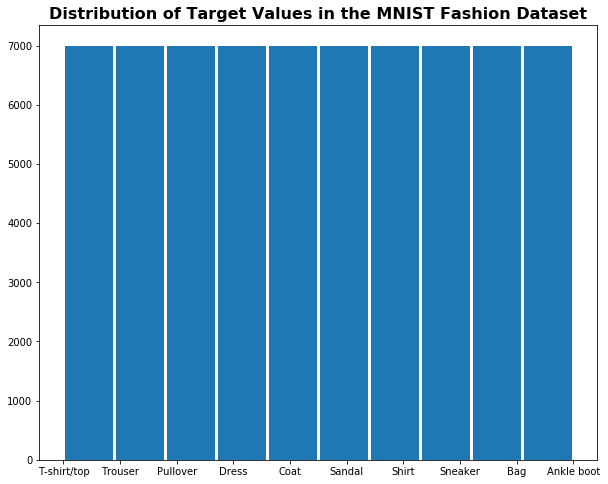

In [10]:
# Plot distribution for entire data set.
plot_y_dist(y)

Then we look to see if this is also true of the training and test subsets, assuming the first 60,0000 items are the training items and the last 10,000 are the test items. Surprisingly, these dats subsets are also uniformly distributed. (Other data subsets were tested (e.g., first 5,000 items) and the distributions are not always perfectly uniform.)

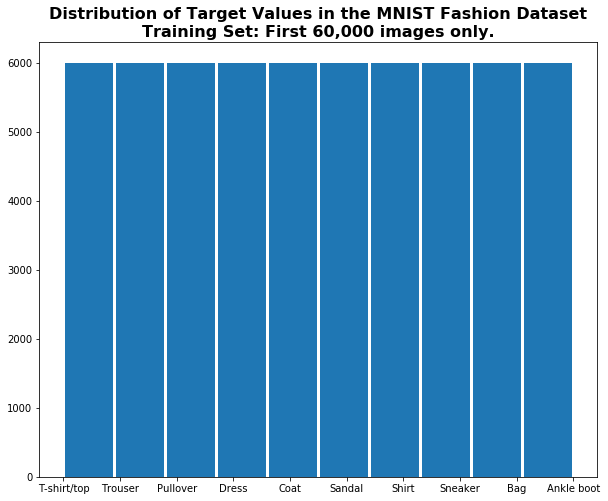

In [11]:
# Sbow the distribution for the training set only.
plot_y_dist(y[0:60000], subtitle='Training Set: First 60,000 images only.')

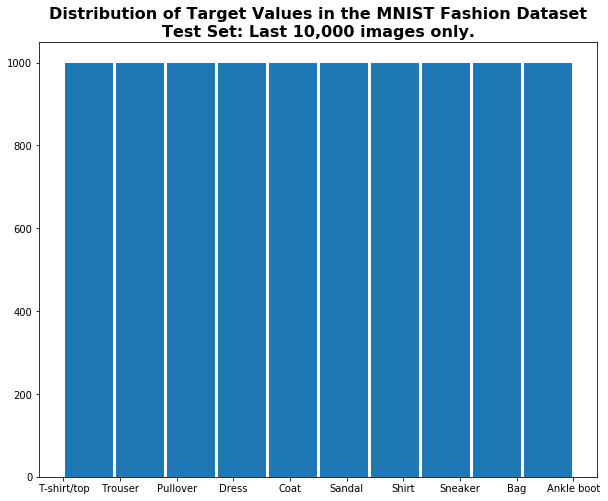

In [12]:
# Sbow the distribution for the training set only.
plot_y_dist(y[60000:70000], subtitle='Test Set: Last 10,000 images only.')

### Display a Selection of Images

['Dress', 'Dress', 'Ankle boot', 'Dress', 'Bag', 'T-shirt/top', 'Dress', 'Pullover', 'Bag', 'Shirt', 'Coat', 'Bag', 'Sneaker', 'Shirt', 'Trouser', 'Shirt', 'Sandal', 'Sneaker', 'Coat', 'Pullover', 'Shirt', 'Sneaker', 'Dress', 'Dress', 'Dress', 'Sneaker', 'Dress', 'Bag', 'Shirt', 'Ankle boot', 'Ankle boot', 'Coat', 'Bag', 'Sneaker', 'Sandal', 'Pullover']


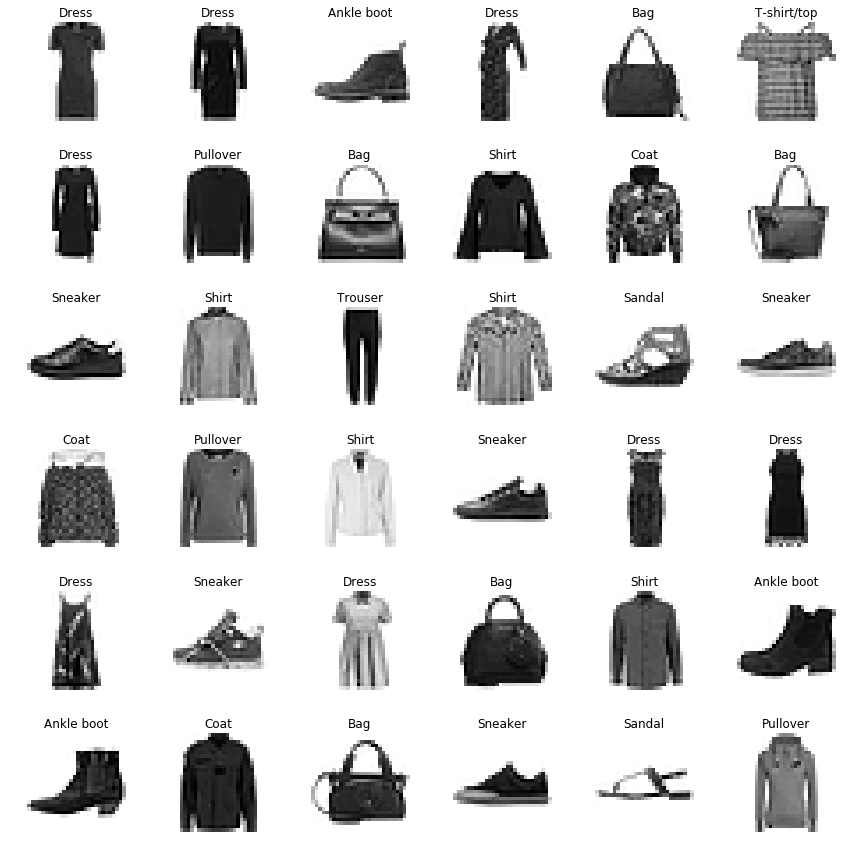

In [13]:
# Create a 6x6 grid of samplea
nrows = ncols = 6
nsamples = nrows * ncols

# Pull a random sample of images to display
random.seed(RSEED)
sample_idx = random.sample(range(total_images), nsamples)
sample_X = [X[i].reshape(28, 28) for i in sample_idx]
sample_X_original = [X[i] for i in sample_idx]
sample_y = [MNF_LABELS[y[i]] for i in sample_idx]
print(sample_y)

# Create a figure with a lot of subplots - one for each sample image
fig = plt.figure(figsize = (12,12))
for i in range(nsamples) :
    
    # Add a subplot with title and image
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.set_title(sample_y[i])
    plt.imshow(sample_X[i], cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

# Pretty the image up and show it.
plt.tight_layout()
plt.show()

### Show Image Pixel Distributions

Take a sample of the images shown above and create a pixel distribution graph in the form of a boxplot for the selected image. 

In [14]:
# Draw a side-by-side plot of an image, and a boxplot of the pixel values of the image. 

def plot_image_and_distribution (image_2d, image_flat, label) :
    nrows = 1 
    ncols = 2
    #image_idx = 34
    #image = sample_X[image_idx]
    #image_original = sample_X_original[image_idx]
    #image_label = sample_y[image_idx]
    title = "Sample {} Image and Boxplot of Pixel Value Distribution".format(image_label)

    # Create a figure with a lot of subplots - one for each sample image
    fig = plt.figure(figsize = (8,8), tight_layout=True)

    # First plot the image
    ax = fig.add_subplot(nrows, ncols, 1)
    ax.set_title(image_label, fontsize=16)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

    # Now plot the distribution
    ax = fig.add_subplot(nrows, ncols, 2)
    #ax.set_title("Pixel Value Distribution")
    plt.boxplot(x=image_original)
    plt.xlabel(image_label)
    plt.xticks([], [])

    # Pretty the image up and show it.
    plt.suptitle(title, fontsize = 16, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()

#### Very Sparce Image

First we show a very space image such as the sandle shown in the bottom row, fifth from the left.

/Users/lta100163/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


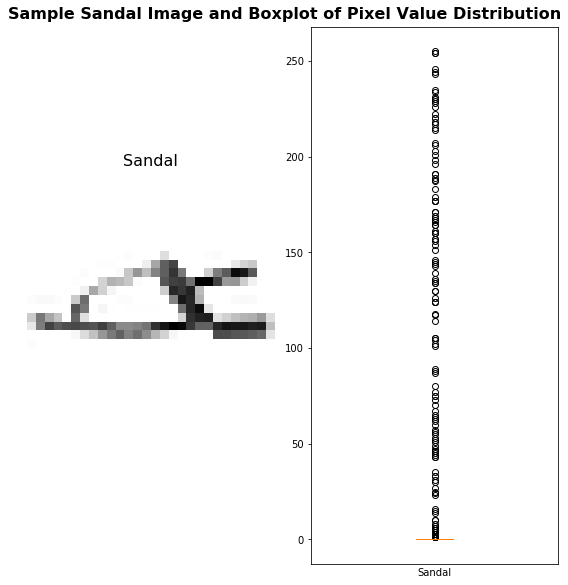

In [15]:
# Very sparce image sample
image_idx = 34
image = sample_X[image_idx]
image_original = sample_X_original[image_idx]
image_label = sample_y[image_idx]
plot_image_and_distribution(
    image_2d=image, 
    image_flat=image_original, 
    label=image_label)

/Users/lta100163/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


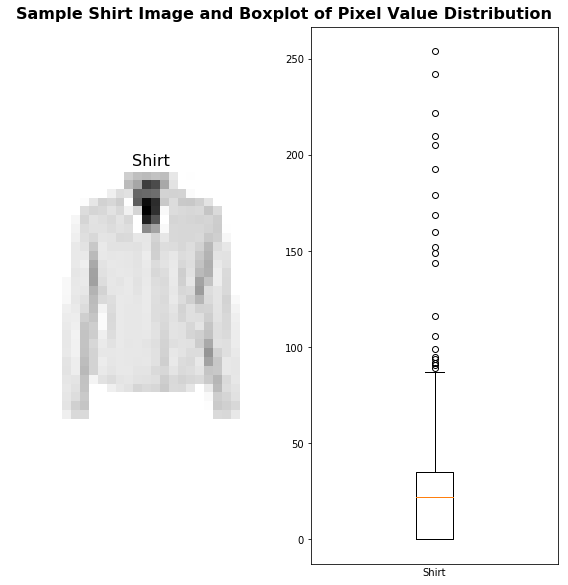

In [16]:
# Very light image sample
image_idx = 20
image = sample_X[image_idx]
image_original = sample_X_original[image_idx]
image_label = sample_y[image_idx]
plot_image_and_distribution(
    image_2d=image, 
    image_flat=image_original, 
    label=image_label)

/Users/lta100163/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


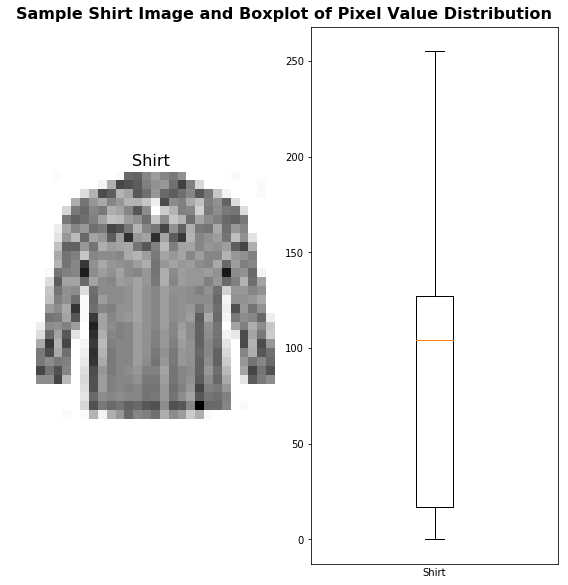

In [17]:
# Very full image sample with middling tones
image_idx = 15
image = sample_X[image_idx]
image_original = sample_X_original[image_idx]
image_label = sample_y[image_idx]
plot_image_and_distribution(
    image_2d=image, 
    image_flat=image_original, 
    label=image_label)

/Users/lta100163/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


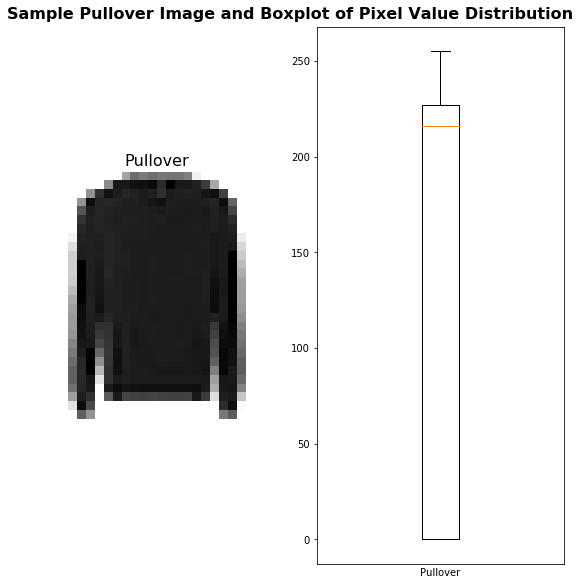

In [18]:
# Very dark and full image sample
image_idx = 7
image = sample_X[image_idx]
image_original = sample_X_original[image_idx]
image_label = sample_y[image_idx]
plot_image_and_distribution(
    image_2d=image, 
    image_flat=image_original, 
    label=image_label)

In [19]:
# This code was developed by Professor John Fox at Syracuse University. 

import numpy as np
from scipy.special import expit
import sys




class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_output : int
      Number of output units, should be equal to the
      number of unique class labels.

    n_features : int
      Number of features (dimensions) in the target dataset.
      Should be equal to the number of columns in the X array.

    n_hidden : int (default: 30)
      Number of hidden units.

    l1 : float (default: 0.0)
      Lambda value for L1-regularization.
      No regularization if l1=0.0 (default)

    l2 : float (default: 0.0)
      Lambda value for L2-regularization.
      No regularization if l2=0.0 (default)

    epochs : int (default: 500)
      Number of passes over the training set.

    eta : float (default: 0.001)
      Learning rate.

    alpha : float (default: 0.0)
      Momentum constant. Factor multiplied with the
      gradient of the previous epoch t-1 to improve
      learning speed
      w(t) := w(t) - (grad(t) + alpha*grad(t-1))
    
    decrease_const : float (default: 0.0)
      Decrease constant. Shrinks the learning rate
      after each epoch via eta / (1 + epoch*decrease_const)

    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent circles.

    minibatches : int (default: 1)
      Divides training data into k minibatches for efficiency.
      Normal gradient descent learning if k=1 (default).

    random_state : int (default: None)
      Set random state for shuffling and initializing the weights.

    Attributes
    -----------
    cost_ : list
      Sum of squared errors after each epoch.

    """
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001, 
                 alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, random_state=None):

        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_labels, n_samples)

        """
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        w1 = np.random.uniform(-1.0, 1.0, size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0, size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)

        Uses scipy.special.expit to avoid overflow
        error for very small input values z.

        """
        # return 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    def _sigmoid_gradient(self, z):
        """Compute gradient of the logistic function"""
        sg = self._sigmoid(z)
        return sg * (1 - sg)

    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1]+1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0]+1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new

    def _feedforward(self, X, w1, w2):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
          Input layer with original features.

        w1 : array, shape = [n_hidden_units, n_features]
          Weight matrix for input layer -> hidden layer.

        w2 : array, shape = [n_output_units, n_hidden_units]
          Weight matrix for hidden layer -> output layer.

        Returns
        ----------
        a1 : array, shape = [n_samples, n_features+1]
          Input values with bias unit.

        z2 : array, shape = [n_hidden, n_samples]
          Net input of hidden layer.

        a2 : array, shape = [n_hidden+1, n_samples]
          Activation of hidden layer.

        z3 : array, shape = [n_output_units, n_samples]
          Net input of output layer.

        a3 : array, shape = [n_output_units, n_samples]
          Activation of output layer.

        """
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        """Compute L2-regularization cost"""
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        """Compute L1-regularization cost"""
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() + np.abs(w2[:, 1:]).sum())

    def _get_cost(self, y_enc, output, w1, w2):
        """Compute cost function.

        y_enc : array, shape = (n_labels, n_samples)
          one-hot encoded class labels.

        output : array, shape = [n_output_units, n_samples]
          Activation of the output layer (feedforward)

        w1 : array, shape = [n_hidden_units, n_features]
          Weight matrix for input layer -> hidden layer.

        w2 : array, shape = [n_output_units, n_hidden_units]
          Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        cost : float
          Regularized cost.

        """
        term1 = -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        """ Compute gradient step using backpropagation.

        Parameters
        ------------
        a1 : array, shape = [n_samples, n_features+1]
          Input values with bias unit.

        a2 : array, shape = [n_hidden+1, n_samples]
          Activation of hidden layer.

        a3 : array, shape = [n_output_units, n_samples]
          Activation of output layer.

        z2 : array, shape = [n_hidden, n_samples]
          Net input of hidden layer.

        y_enc : array, shape = (n_labels, n_samples)
          one-hot encoded class labels.

        w1 : array, shape = [n_hidden_units, n_features]
          Weight matrix for input layer -> hidden layer.

        w2 : array, shape = [n_output_units, n_hidden_units]
          Weight matrix for hidden layer -> output layer.

        Returns
        ---------

        grad1 : array, shape = [n_hidden_units, n_features]
          Gradient of the weight matrix w1.

        grad2 : array, shape = [n_output_units, n_hidden_units]
            Gradient of the weight matrix w2.

        """
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))

        return grad1, grad2

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
          Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
          Predicted class labels.

        """
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                 'Use X[:,None] for 1-feature classification,'
                                 '\nor X[[i]] for 1-sample classification')

        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred

    # FUNCTION FOR FITTING MLP 
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data.

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
          Input layer with original features.

        y : array, shape = [n_samples]
          Target class labels.

        print_progress : bool (default: False)
          Prints progress as the number of epochs
          to stderr.

        Returns:
        ----------
        self

        """
        
        global learnrate
        
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):
            
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)
            learnrate[i] = self.eta

            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx], output=a3, w1=self.w1, w2=self.w2)
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(
                    a1=a1, a2=a2, a3=a3, z2=z2, y_enc=y_enc[:, idx], w1=self.w1, w2=self.w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self

In [20]:
nepochs = 1500  # 1000
nhidden = 125

learnrate = [0] * nepochs

# ORIGINAL VALUES
'''
nn = NeuralNetMLP(
    n_output=10,                   # 10
    n_features=X_train.shape[1],   # X_train.shape[1] - DO NOT CHANGE
    n_hidden=nhidden,
    l2=0.1,                        # 0.1
    l1=0.1,                        # 0.0
    epochs=nepochs,                   # 1000
    eta=0.001,                     # 0.001
    alpha=0.001,                   # 0.001
    decrease_const=0.00001,        # 0.00001
    minibatches=50,                # 50
    shuffle=True,                  # True
    random_state=RSEED)                # 1
'''

#nn = NeuralNetMLP(n_output=10, n_features=X_train.shape[1])

nn = NeuralNetMLP(
    n_output=10, n_features=X_train.shape[1], n_hidden=30, l1=0.0, l2=0.0, epochs=500, eta=0.001, alpha=0.0,
    decrease_const=0.0, shuffle=True, minibatches=10, random_state=None)

In [21]:
%%time 

nn.fit(X_train, y_train, print_progress=True)

Epoch: 500/500

CPU times: user 15min 36s, sys: 3min 47s, total: 19min 23s
Wall time: 7min 20s


|n_hidden|l2  |l1 |epochs|eta    |alpha|decrease_const|minibatches|time (sec)|test error |train error|
|--------|----|---|------|-------|-----|--------------|-----------|----------|-----------|-----------|
|350     |0.1 |0.0|2500  |0.00001|0.001|0.000001      |100        |5760      |19.04%     |           |
|100     |0.1 |0.0|500   |0.00001|0.001|0.000001      |100        |636       |21.30%     |           |
|100     |0.0 |0.0|500   |0.001  |0.001|0.000001      |100        |492       |22.75%     |           |
|100     |0.25|0.0|500   |0.001  |0.001|0.000001      |100        |473       |39.22%     |           |
|100     |0.1 |0.1|500   |0.00001|0.001|0.000001      |100        |514       |34.21%     |           |
|100     |0.1 |0.1|500   |0.00001|0.001|0.000001      |50         |502       |32.85%     |           |
|200     |0.1 |0.1|500   |0.00001|0.001|0.000001      |50         |712       |33.83%     |           |
|75      |0.1 |0.1|500   |0.00001|0.001|0.000001      |50         |428       |28.80%     |           |
|75      |0.1 |0.1|1000  |0.00001|0.001|0.000001      |50         |806       |27.57%     |           |
|150     |0.1 |0.1|1000  |0.00001|0.001|0.000001      |50         |1057      |25.49%     |           |
|125     |0.1 |0.1|1250  |0.00001|0.001|0.000001      |50         |1493      |14.66%     |11.31%     |
|125     |0.1 |0.1|1500  |0.00001|0.001|0.000001      |50         |1823      |14.67%     |11.28%     |
|150     |0.1    |0.1    |1500  |0.00001|0.001|0.000001      |50         |1823      |14.67%     |11.28%     |
|default |default|default|default|default|default|default|default|474       |90.00%     |90.00%     |

In [22]:
yhat = nn.predict(X_train)
testy = (y_train == yhat)
testy = (testy == False)
errorn = testy.sum()
totaln = len(testy)
print("From the train set we predicted {} incorrectly out of {} ({:.2%})".format(errorn, totaln, errorn/totaln) )

From the train set we predicted 17880 incorrectly out of 60000 (29.80%)


In [23]:
yhat = nn.predict(X_test)
testy = (y_test == yhat)
testy = (testy == False)
errorn = testy.sum()
totaln = len(testy)
print("From the test set we predicted {} incorrectly out of {} ({:.2%})".format(errorn, totaln, errorn/totaln) )

From the test set we predicted 3025 incorrectly out of 10000 (30.25%)


In [24]:
NaN = float('nan')

n_hidden    = [  350,   100,   100,   100,   100,   100,   200,    75,    75,   150,   125,   125,   150]
l2          = [  0.1,   0.1,   0.0,  0.25,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1]
l1          = [  0.0,   0.0,   0.0,   0.0,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1,   0.1]
epochs      = [ 2500,   500,   500,   500,   500,   500,   500,   500,  1000,  1000,  1250,  1500,  1500]
minibatches = [  100,   100,   100,   100,   100,    50,    50,    50,    50,    50,    50,    50,    50]
time        = [ 5760,   636,   492,   473,   514,   502,   712,   428,   806,  1057,  1493,  1823,  1823]
test_error  = [19.04, 21.30, 22.75, 39.22, 34.21, 32.85, 33.83, 28.80, 27.57, 25.49, 14.66, 14.67, 14.67]
train_error = [  NaN,   NaN,   NaN,   NaN,   NaN,   NaN,   NaN,   NaN,   NaN,   NaN, 11.31, 11.28, 11.28]
alpha          = [0.001]    * 13
decrease_const = [0.000001] * 13
eta    = [0.00001, 0.00001, 0.001,   0.001,   0.00001, 0.00001, 0.00001,
          0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001]
       

d = {'n_hidden': n_hidden, 'l2': l2, 'l1': l1, 'epochs': epochs, 'eta': eta, 'alpha': alpha,
     'decrease_const': decrease_const, 'minibatches': minibatches, 'time': time, 'test_error': test_error,
     'train_error': train_error}

df = pd.DataFrame(d)
df

,n_hidden,l2,l1,epochs,eta,alpha,decrease_const,minibatches,time,test_error,train_error
0,350,0.10,0.0,2500,0.00001,0.001,0.000001,100,5760,19.04,NaN
1,100,0.10,0.0,500,0.00001,0.001,0.000001,100,636,21.30,NaN
2,100,0.00,0.0,500,0.00100,0.001,0.000001,100,492,22.75,NaN
3,100,0.25,0.0,500,0.00100,0.001,0.000001,100,473,39.22,NaN
4,100,0.10,0.1,500,0.00001,0.001,0.000001,100,514,34.21,NaN
5,100,0.10,0.1,500,0.00001,0.001,0.000001,50,502,32.85,NaN
6,200,0.10,0.1,500,0.00001,0.001,0.000001,50,712,33.83,NaN
7,75,0.10,0.1,500,0.00001,0.001,0.000001,50,428,28.80,NaN
8,75,0.10,0.1,1000,0.00001,0.001,0.000001,50,806,27.57,NaN
9,150,0.10,0.1,1000,0.00001,0.001,0.000001,50,1057,25.49,NaN


In [25]:
y = df.test_error
X = df.loc[:, ('n_hidden', 'l1', 'l2', 'epochs', 'minibatches')]
model = sm.OLS(y, X)
results = model.fit()
results.summary()

/Users/lta100163/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             test_error   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     74.57
Date:                Fri, 07 Jun 2019   Prob (F-statistic):           1.71e-06
Time:                        17:36:42   Log-Likelihood:                -35.955
No. Observations:                  13   AIC:                             81.91
Df Residuals:                       8   BIC:                             84.73
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
n_hidden        0.0687      0.031      2.204      0.059      -0.003       0.140
l1            110.5572     25.128      4.400      0.002      52.613     168.502
l2             75.3934     26.407      2.855      0.021      14.499     136.288
epochs         -0.0134      0.004     -3.706      0.006      -0.022      -0.005
minibatches     0.1894      0.046      4.099      0.003       0.083       0.296
==============================================================================
Omnibus:                        0.424   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.809   Jarque-Bera (JB):                0.521
Skew:                           0.248   Prob(JB):                        0.771
Kurtosis:                       2.154   Cond. No.                     2.53e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
y = df.time
X = df.loc[:, ('n_hidden', 'l1', 'l2', 'epochs', 'minibatches')]
#X = df.loc[:, ('n_hidden', 'l2', 'epochs')]

model = sm.OLS(y, X)
results = model.fit()
results.summary()

/Users/lta100163/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     76.14
Date:                Fri, 07 Jun 2019   Prob (F-statistic):           1.58e-06
Time:                        17:36:42   Log-Likelihood:                -91.205
No. Observations:                  13   AIC:                             192.4
Df Residuals:                       8   BIC:                             195.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
n_hidden        6.8059      2.184      3.116      0.014       1.769      11.843
l1          -7408.2016   1761.602     -4.205      0.003   -1.15e+04   -3345.941
l2          -1261.2618   1851.286     -0.681      0.515   -5530.335    3007.811
epochs          1.4714      0.254      5.791      0.000       0.885       2.057
minibatches    -5.3301      3.239     -1.646      0.138     -12.799       2.139
==============================================================================
Omnibus:                        1.458   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.482   Jarque-Bera (JB):                1.122
Skew:                           0.546   Prob(JB):                        0.571
Kurtosis:                       2.062   Cond. No.                     2.53e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
y_new = df.test_error.mul(-0.01).add(1)

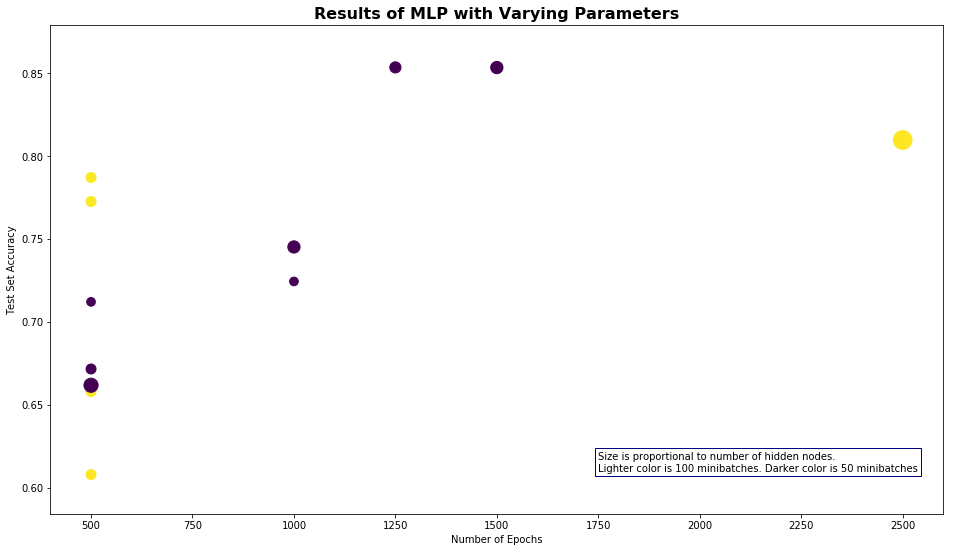

In [28]:
fig, ax = plt.subplots(figsize = (16,9))
plt.scatter(y=y_new, x=X.epochs, s=X.n_hidden, c=X.minibatches)
plt.title('Results of MLP with Varying Parameters', fontsize=16, fontweight='bold')
plt.ylabel('Test Set Accuracy')
plt.xlabel('Number of Epochs')
legtxt = "Size is proportional to number of hidden nodes.\n" +\
  "Lighter color is 100 minibatches. Darker color is 50 minibatches"
bbox = dict(boxstyle="square", facecolor = "white", edgecolor='navy')
plt.text(1750, 0.61, legtxt, bbox=bbox)
plt.show()

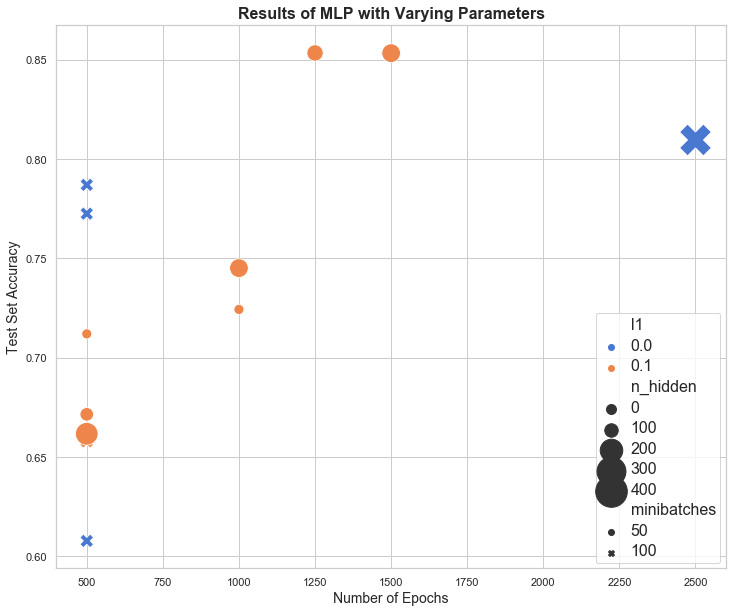

In [29]:
import seaborn as sns;

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize = (12,10))
g = sns.scatterplot(
    ax=ax, 
    y = y_new, x=X.epochs, 
    size=X.n_hidden, sizes=(100, 1000), 
    style=X.minibatches, 
    hue=X.l1, palette=sns.color_palette("muted", n_colors=2))
#plt.scatter(y=y_new, x=X.epochs, s=X.n_hidden, c=X.minibatches)
plt.title('Results of MLP with Varying Parameters', fontsize=16, fontweight='bold')
plt.ylabel('Test Set Accuracy', fontsize=14)
plt.xlabel('Number of Epochs', fontsize=14)
#legtxt = "Size is proportional to number of hidden nodes.\n" +\
#  "Lighter color is 100 minibatches. Darker color is 50 minibatches"
#bbox = dict(boxstyle="square", facecolor = "white", edgecolor='navy')
#plt.text(1750, 0.61, legtxt, bbox=bbox)
plt.setp(ax.get_legend().get_texts(), fontsize='16') # for legend text
#plt.setp(ax.get_legend().get_title(), fontsize='32') # for legend title
plt.show()

<bound method Figure.show of <Figure size 864x720 with 1 Axes>>

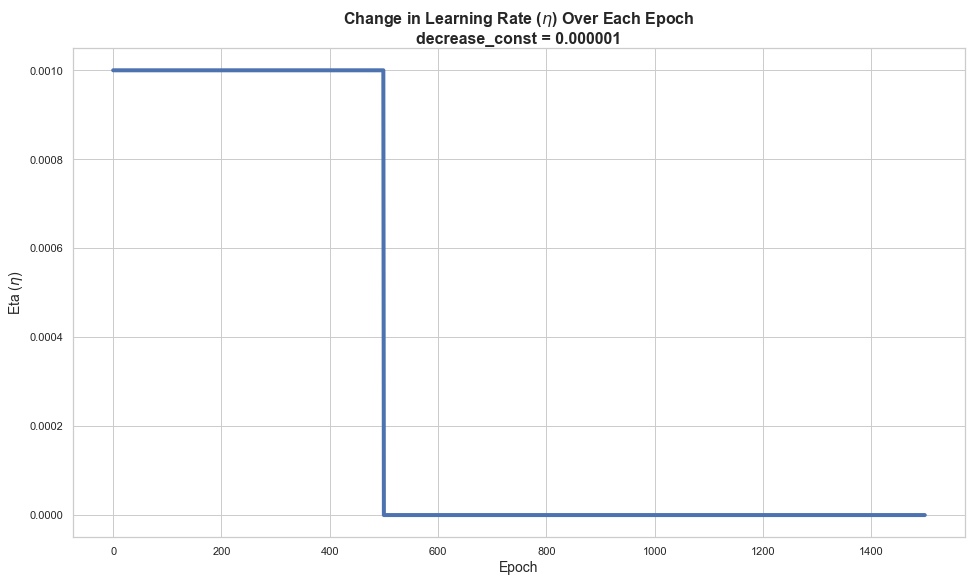

In [30]:
fig.ax = plt.subplots(figsize = (16,9))
plt.plot(learnrate, linewidth=4)
plt.title("Change in Learning Rate (" + r'$\eta$' + ") Over Each Epoch\ndecrease_const = 0.000001", fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Eta ('+ r'$\eta$' + ')', fontsize=14)
fig.show